# **Introduction**

In recent years, **deep learning** has made significant advances in the field of **image segmentation**, a critical task in medical and satellite imaging, autonomous driving, and more. Traditionally, Convolutional Neural Networks (CNNs) have dominated segmentation tasks, with architectures like **U-Net**, **DeepLab**, and **Mask R-CNN** setting the standard for state-of-the-art performance. These models leverage hierarchical feature extraction and local spatial relationships through convolutions, making them highly effective for dense prediction tasks. However, with the evolution of deep learning, new architectures like **Vision Transformers (ViTs)** have emerged, providing an alternative approach to handling spatial relationships and global context in images.

Vision Transformers bring the strength of transformer architectures, originally developed for natural language processing, to computer vision tasks. By dividing an image into patches and treating these patches as sequences, Vision Transformers excel at capturing both local and global context within images. This enables ViTs to recognize subtle patterns and structures that may be challenging for CNNs, making them especially suited for applications where capturing fine details across an image is crucial, such as medical and satellite imagery analysis.

In my previous [work](https://www.kaggle.com/code/jerometam/visiontransformer-for-images-classification), I explored Vision Transformers in medical imaging, for **pneumonia classification from chest X-rays**. Now, in this notebook, we extend this exploration of ViTs to a new domain: **imagery segmentation**. Here, we will apply Vision Transformers to identify and segment buildings in satellite images, a task that requires precise boundary detection and the ability to handle complex patterns in urban environments.

## **Objectives**

1. **Understand Vision Transformers for Segmentation**: Gain insights into how Vision Transformers work and why they are effective for segmentation tasks.
2. **Implement and Train a Vision Transformer for Satellite Image Segmentation**: Apply a Vision Transformer model to segment buildings in satellite images, building on previous work in medical image classification.

By the end of this notebook, we'll understand how Vision Transformers can be applied beyond classification, leveraging their capabilities for segmentation tasks in real-world applications, such as satellite imagery analysis. 

Let's dive into Vision Transformers and explore their potential in advancing segmentation performance in satellite imaging!


# Basic Import

In [45]:
import os
import json
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.path import Path

from PIL import Image
from skimage.io import imread
from skimage.util import montage  
from skimage.io import imread, imsave
from skimage.color import label2rgb

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import functional as TF
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", message=".*is a low contrast image.*")

map_base_dir = '/kaggle/input/synthetic-word-ocr'
map_img_dir = '/kaggle/input/synthetic-word-ocr/train/images/'

# **Data Preprocessing Overview**

In this section, we prepare the data for segmentation by generating masks from polygon annotations, splitting the dataset into train and test sets, and saving the processed images and masks.





In [2]:
# Load and merge annotations
json_path = os.path.join(map_base_dir, 'annotation.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

In [3]:
# Convert image and annotation data into DataFrames
image_df = pd.DataFrame(annot_data['images'])
annot_df = pd.DataFrame(annot_data['annotations'])

# Merge annotations with image metadata on `image_id`
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])


In [6]:

def rows_to_segmentation(in_img, in_df):
    """ 
    Converts polygon annotations into binary masks.
    
    For each polygon, calculates the pixels it covers, 
    resulting in a mask where the buildings are highlighted
    
    """
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

In [7]:
#Splitting the Dataset

tmp = list(full_df.groupby('image_id'))
train_df = tmp[0:5000]
test_df = tmp[5000:7000]

In [8]:
def save_images_and_masks(in_df, image_dir,save_dir):
    """ 
    Saves images and their generated masks in separate directories.
        
    Tracks image and mask paths to save later in CSV files for easy access.
    
    """
    image_ids = []
    for idx, (image_id, df) in enumerate(in_df):

        img_path = os.path.join(image_dir, df['file_name'].values[0])
        img_data = imread(img_path)
        

        mask = rows_to_segmentation(img_data, df)
        
 
        mask = (mask * 255).astype(np.uint8)
     
        
  


        image_save_path = os.path.join(save_dir+'images', f"{image_id}.png")
        imsave(image_save_path, img_data)
        

        mask_save_path = os.path.join(save_dir+'masks', f"{image_id}_mask.png")
        mask_uint8 = (mask * 255).astype(np.uint8)  # Scale the mask to [0, 255] range
        mask_image = Image.fromarray(mask_uint8, mode='L') 
        imsave(mask_save_path, mask)
        
        image_ids.append([image_id, image_save_path, mask_save_path])
        
    print(f"Saved image and mask")
    return image_ids

In [9]:
"""
Creates directories for images and masks.

Saves image and mask paths in CSV files for easy access during model training.

"""
save_dir_ = "/kaggle/working/train/"
save_dir = "/kaggle/working/test/"

os.makedirs(save_dir_+'images', exist_ok=True)
os.makedirs(save_dir_+'masks', exist_ok=True)

os.makedirs(save_dir+'images', exist_ok=True)
os.makedirs(save_dir+'masks', exist_ok=True)

image_ids_train = save_images_and_masks(in_df=train_df, image_dir= map_img_dir, 
                      save_dir=save_dir_)

image_ids_test = save_images_and_masks(in_df=test_df, image_dir= map_img_dir, 
                      save_dir=save_dir)



Saved image and mask
Saved image and mask


In [10]:
image_ids_train= pd.DataFrame(image_ids_train, columns=['image_id', 'image_path', 'mask_path'])
image_ids_train.to_csv(save_dir_+"train_ids.csv", index=False)

image_ids_test= pd.DataFrame(image_ids_test, columns=['image_id', 'image_path', 'mask_path'])
image_ids_test.to_csv(save_dir+"test_ids.csv", index=False)

In [11]:
# Load Dataset
train_ids = pd.read_csv("/kaggle/working/train/train_ids.csv")
test_ids = pd.read_csv("/kaggle/working/test/test_ids.csv")

# **Patch Extraction Process**

We preprocess each satellite image by dividing it into smaller, non-overlapping patches to be used as input tokens for our Vision Transformer. This method of patch extraction is essential for Vision Transformers, as it allows the model to treat each patch as a separate token and learn relationships across the image. With an image size of $300$x$300$ and a patch size of $10$x$10$, each image is divided into $900$ patches $(300 / 10 = 30$ patches along each dimension, resulting in $30$ x $30$ = $900$total patches).

### **Steps in Patch Extraction**

1. **Patch Division**: Each image is divided into non-overlapping patches of fixed size (10x10 in this case). This segmentation allows us to handle parts of the image individually, making it easier for the model to process and analyze complex spatial structures.

2. **Flattening**: Once patches are extracted, they are flattened to 1D vectors, allowing the patches to be processed as individual tokens. By representing each patch as a vector, we prepare the data in a way that is compatible with the Vision Transformer’s input format.

3. **Patch Projection (Tokenization)**: After flattening, each patch is projected into a higher-dimensional space. This projection step allows the model to map each patch into a feature space where spatial relationships can be learned more effectively.

Using patches reduces computational complexity by dividing the image into smaller parts, enabling the transformer to process relationships between different sections of the image independently. This structure is especially beneficial for tasks like segmentation, where identifying boundaries and structures across large areas is crucial.

By splitting each image into patches, we also take advantage of the Vision Transformer’s strength in modeling spatial relationships, allowing it to capture nuanced patterns in satellite images for building segmentation.

# **Binary Cross-Entropy Dice Loss (BCE-Dice Loss)**

To improve segmentation performance, we use a loss function called **BCE-Dice Loss**, which combines two powerful loss functions:

1. **Binary Cross-Entropy (BCE) Loss**: Measures the pixel-wise error between the predicted mask and the ground truth mask by comparing each pixel independently. BCE is effective in ensuring accuracy at the pixel level, making it suitable for binary segmentation tasks.

2. **Dice Loss**: Complements BCE by focusing on the overlap between predicted and actual regions in the mask, optimizing for the model’s ability to capture the entire target structure (e.g., buildings). Dice Loss is particularly useful for improving segmentation accuracy on imbalanced datasets by emphasizing regions of the image that belong to the target class.

Combining BCE and Dice Loss leverages the strengths of both: the pixel accuracy of BCE and the structural consistency of Dice Loss, providing a balanced approach to improve segmentation performance, especially in tasks with complex and detailed masks like satellite image segmentation.

Together, patch extraction and BCE-Dice Loss form the backbone of our model’s approach to satellite image segmentation. With this foundation, we’re now ready to implement and train our Vision Transformer model.


In [15]:
class CustomDataset(Dataset):
    def __init__(self, in_df, patch_size=16, transform=None,limit=None):
        
        self.df = in_df
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.df)

    def extract_patches(self, img, patch_size):

        patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(3, -1, patch_size, patch_size)  # Flatten patches
        return patches.permute(1, 0, 2, 3)  # Shape [num_patches, C, patch_size, patch_size]

    def __getitem__(self, idx):
        img_id,img_path,mask_path = self.df.iloc[idx]

        img_data = imread(img_path)
        seg_data = np.expand_dims(imread(mask_path), -1)

        if self.transform:
            img_data = self.transform(img_data)
        else:
            img_data = torch.tensor(img_data, dtype=torch.float32).permute(2, 0, 1)
        
        seg_data = torch.tensor(seg_data, dtype=torch.float32).permute(2, 0, 1)
        
        img_patches = self.extract_patches(img_data, self.patch_size) 



        return img_patches, seg_data/ 255.0 


In [28]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()  
    
    def forward(self, outputs, targets):

        bce_loss = self.bce_loss(outputs, targets)
        

        dice_coeff = self.dice_coeff(torch.sigmoid(outputs), targets) 

        total_loss = bce_loss + (1 - dice_coeff)
        return total_loss,dice_coeff
    
    def dice_coeff(self, outputs, targets, smooth=1):

        outputs = outputs.view(-1)
        targets = targets.view(-1)
        

        intersection = (outputs * targets).sum()
        dice_coeff = (2. * intersection + smooth) / (outputs.sum() + targets.sum() + smooth)
        

        return dice_coeff


# **Vision Transformer (ViT) Model for Image Segmentation**

This section provides a comprehensive overview of the Vision Transformer (ViT) architecture used for image segmentation in this notebook. The model is designed to take satellite images, split them into patches, process these patches through transformer encoders, and produce segmentation masks. Below is a detailed breakdown of each component.

---

## 1. Patch Embedding Layer (`PatchEmbedding`)

The Vision Transformer processes images as sequences of patches rather than pixels. Each patch is embedded into a vector, which serves as a token for the transformer.

- **Patch Division**: The input image is divided into non-overlapping patches, each of which becomes an individual input token.
- **Linear Projection**: A linear layer projects each flattened patch into a high-dimensional embedding space. This embedding is crucial, as it transforms each patch into a meaningful representation in the model’s latent space.

By embedding the patches, the model can represent each part of the image as a unique token, forming the input tokens for the transformer encoders.

---

## 2. Positional Encoding

Transformers lack intrinsic spatial awareness, which is essential for understanding the arrangement of patches in an image. Positional encoding solves this by introducing spatial information.

- **Positional Encoding**: A learnable parameter (`position_embedding`) is added to each patch embedding, allowing the model to capture the relative position of each patch. This addition provides spatial context, helping the model recognize spatial relationships between patches, which is crucial for accurate segmentation.

---

## 3. Transformer Encoder Layers

The core of the model consists of a series of encoder layers, each designed to process and refine the patch embeddings. Here, we use six transformer encoders, each focusing on capturing complex spatial relationships within the image.

- **Multi-Head Self-Attention**: Each encoder layer uses a multi-head attention mechanism to allow each patch to attend to all other patches. This helps capture both local and global relationships in the image.
- **Feed-Forward Layers**: After the attention mechanism, two fully connected layers are applied sequentially to refine the embeddings. A GELU activation function is used between the layers to introduce non-linearity.
- **Layer Normalization and Residual Connections**: Each encoder layer includes layer normalization and residual connections, which help stabilize training and improve model convergence.

The stacked encoder layers enable the model to learn hierarchical representations of the image, enhancing its ability to understand complex spatial patterns necessary for segmentation.

---

## 4. Segmentation Head (`fc_segmentation`, `seg_drop`, and `F.interpolate`)

After processing the patch embeddings through the encoder layers, the model reshapes the embeddings and passes them through the segmentation head to produce the final segmentation map at the original image resolution.

- **Reshaping and Projection**: The output tokens from the encoder are reshaped back into a spatial representation, corresponding to the layout of the original patches.
- **Convolutional Layer (`fc_segmentation`)**: A 2D convolutional layer with a kernel size of 3 is applied to map the reshaped embeddings into the required number of output channels (e.g., for binary or multi-class segmentation), capturing spatial details in the output mask.
- **Dropout Layer (`seg_drop`)**: A dropout layer helps improve model generalization by reducing overfitting.
- **Upsampling with Interpolation**: The output is upsampled to the original image dimensions using bilinear interpolation (`F.interpolate`), ensuring that the segmentation mask aligns with the input image size.

This sequence ensures that the model generates segmentation masks at the correct resolution, making the output more interpretable and useful for real-world applications.

---

## 5. Binary Cross-Entropy Dice Loss (BCE-Dice Loss)

For training the model, we use **BCE-Dice Loss**, a combination of Binary Cross-Entropy (BCE) Loss and Dice Loss. This combination offers the benefits of both pixel-level accuracy (through BCE) and regional accuracy (through Dice Loss), which is particularly useful in segmentation tasks where some regions may be small or imbalanced.

- **Binary Cross-Entropy (BCE)**: Measures pixel-wise accuracy by calculating the loss between each predicted pixel and its ground truth counterpart. It is effective for pixel-level precision in segmentation tasks.
- **Dice Loss**: Focuses on the overlap between the predicted and actual regions, optimizing the model to capture entire regions rather than isolated pixels. This is particularly beneficial for imbalanced datasets, as it emphasizes the correct segmentation of smaller regions.

By combining BCE and Dice Loss, we ensure that the model learns both accurate and cohesive segmentation outputs, critical for high-quality results.

---

## Summary

This Vision Transformer-based model combines patch embeddings, transformer encoders, and a carefully designed segmentation head to achieve accurate image segmentation. By leveraging the transformer’s ability to capture spatial relationships, the model excels in understanding and segmenting complex satellite images. In the next steps, we’ll train the model using the BCE-Dice Loss and evaluate its performance on our dataset.






In [48]:
class PatchEmbedding(nn.Module):
    def __init__(self,  patch_dim,emb_dim):
        super(PatchEmbedding, self).__init__()
        
        self.linear_proj = nn.Sequential(
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, emb_dim),
            nn.Dropout(0.3)
        )
    def forward(self, x):
        x = self.linear_proj(x)
        return x
    
class Encoder(nn.Module):
    def __init__(self,emb_dim):
        super(Encoder, self).__init__()
        self.attn = torch.nn.MultiheadAttention(embed_dim = emb_dim,
                                                num_heads=8,
                                                dropout=0.2,
                                                batch_first=True)
        
        self.linear1 = nn.Linear(in_features = emb_dim,out_features = emb_dim*4)
        self.linear2 = nn.Linear(in_features = emb_dim*4,out_features = emb_dim)
        
        self.norm1 = nn.LayerNorm(normalized_shape = emb_dim)
        self.norm2 = nn.LayerNorm(normalized_shape = emb_dim)
        
        self.dropout1 = torch.nn.Dropout(0.3)
        self.dropout2 = torch.nn.Dropout(0.3)
        self.dropout3 = torch.nn.Dropout(0.3)
        
    def forward(self,x,attn_mask=None,key_padding_mask=None):

        x_tmp = self.norm1(x)

        x_tmp, _ = self.attn(query=x_tmp,
                             key=x_tmp,
                             value=x_tmp,
                             attn_mask=attn_mask,
                             key_padding_mask=key_padding_mask)

        x_tmp = self.dropout1(x_tmp)
        x = x + x_tmp
        
        x_tmp = self.norm2(x) 
        x_tmp = self.linear1(x_tmp)
        x_tmp = F.gelu(x_tmp)
            
        x_tmp = self.dropout2(x_tmp)
        x_tmp = self.linear2(x_tmp)
        x_tmp = self.dropout3(x_tmp)
        x = self.norm1(x + x_tmp)
        
            
        return x

class VisionTransformerSegmentation(nn.Module):
    def __init__(self,device, in_channels, out_channel,emb_dim, image_size=300, patch_size=10):
        super(VisionTransformerSegmentation, self).__init__()
        
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size

        self.num_patches = (image_size // patch_size) ** 2
        self.patch_embedding = PatchEmbedding(patch_dim,emb_dim)
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches,emb_dim))
        
        self.encoder1 = Encoder(emb_dim)
        self.encoder2 = Encoder(emb_dim)
        self.encoder3 = Encoder(emb_dim)
        self.encoder4 = Encoder(emb_dim)
        self.encoder5 = Encoder(emb_dim)
        self.encoder6 = Encoder(emb_dim)
        
        self.fc_segmentation = nn.Conv2d(emb_dim, out_channel, kernel_size=3)
        self.seg_drop = nn.Dropout(0.3)
        
        self.patch_size = patch_size
        self.img_size = image_size
        self.emb_dim = emb_dim
        
        self.device = device

    def forward(self, x):
        x = x.to(self.device)
        batch_size, num_patches, channels, patch_size, _ = x.size()
        x = x.view(batch_size, num_patches, -1)
        
        x = self.patch_embedding(x)

        x = x + self.position_embedding[:, :(num_patches)]

        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        
        x = self.encoder4(x)
        x = self.encoder5(x)
        x = self.encoder6(x)

        x = x.view(batch_size, self.num_patches, self.emb_dim)
        x = x.permute(0, 2, 1).contiguous().view(batch_size, self.emb_dim, self.img_size // self.patch_size, self.img_size // self.patch_size)
        

        x = self.fc_segmentation(x)
        x = self.seg_drop(x)

        x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)

        return x

    def calculate_test_loss(self, test_loader, criterion):
        self.to(self.device) 
        loss_mean = 0.0
        self.eval()
        dice_coeff_mean = 0.0
        with torch.no_grad():
            for i, batch in enumerate(test_loader):
                patches, target = batch[0].to(self.device), batch[1].to(self.device)
          
                output = self(patches)
                test_loss,dice_coeff = criterion(output, target)

                loss_mean += test_loss.item()
                dice_coeff_mean += dice_coeff.item()
                

        loss_mean = np.round(loss_mean/(i+1), 5)
        dice_coeff_mean = np.round(dice_coeff_mean/(i+1), 5)
        return loss_mean,dice_coeff_mean

    @torch.no_grad()
    def inference(self, patches):
        self.eval() 

       
        patches = patches.to(next(self.parameters()).device)

        
        output = self(patches)
        return output
    
    def train_model(self, train_loader, 
                    test_loader, optimizer, 
                    scaler, criterion, 
                    train_saved_path, test_saved_path,epoch = None):
        
        self.to(self.device) 

        best_train_loss = float("inf")
        best_test_loss = float("inf")
        ep = 0
        
        if os.path.isfile(""):
            state = torch.load("")
            self.load_state_dict(state["model"])
            optimizer.load_state_dict(state["optimizer"])
            ep = state["epoch"] + 1
            best_train_loss = state.get("train_loss", float("inf"))
            best_test_loss = state.get("test_loss", float("inf"))
            print(f"Continue training from epoch {ep} with train_loss: {best_train_loss} and test_loss: {best_test_loss}")
        else:
            print("Start from Scratch")
            
        in_train = True  
        while in_train:
            self.train()
            train_loss = 0.0
            dice_train = 0.0

            for i, batch in enumerate(train_loader):
                patches, target = batch[0].to(self.device), batch[1].to(self.device) 

                optimizer.zero_grad()  

                with torch.amp.autocast(device_type='cuda'):
                    output = self(patches)
                    loss,dice_coeff = criterion(output, target)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()

                train_loss += loss.item()
                dice_train += dice_coeff.item()

            test_loss,dice_test = self.calculate_test_loss(test_loader, criterion)
            train_loss = np.round(train_loss/(i+1), 5) 
            dice_train = np.round(dice_train/(i+1), 5)
            ep += 1
            if ep != 0 and ep%10 == 0:
                state = {"model": self.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "epoch": ep,
                         "train_loss": train_loss,
                         "test_loss": test_loss}
                
                if train_loss < best_train_loss:
                    print(f"Epoch {ep}: Saving best train model")
                    torch.save(state, train_saved_path)
                    best_train_loss = train_loss
                if test_loss < best_test_loss:
                    print(f"Epoch {ep}: Saving best test model")
                    torch.save(state, test_saved_path)
                    best_test_loss = test_loss

            print(f"Epoch {ep}: Train loss: {train_loss}, Test loss: {test_loss}, DiceCoeff Train: {dice_train},DiceCoeff Test: {dice_test}")
            
            if epoch is not None and ep >= epoch:
                state = {"model": self.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "epoch": ep,
                         "train_loss": train_loss,
                         "test_loss": test_loss}
                torch.save(state, train_saved_path)
                torch.save(state, test_saved_path)
                in_train = False
                print("Training complete")


# **Model Training**

Here are the key configurations for our training setup:

- **Image Size** : 300x300 pixels.
- **Patch Size** : 10x10 pixels, yielding a sequence of 900 patches per image.
- **Embedding Dimension** : Each patch is projected to an embedding dimension of 256 (128x2).
- **Batch Size** : 4
- **Learning Rate** : $1 \times 10^{-4}$
- **Epochs** : The model will be trained for 50 epochs.
- **GPU** : GPU P100.

The training process will involve monitoring the model’s loss and dice-coeff


In [49]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
    
train_dataset = CustomDataset(in_df=train_ids, patch_size=10, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2,pin_memory=True)


valid_dataset = CustomDataset(in_df=test_ids, patch_size=10, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=2,pin_memory=True)

train_saved_path = "/kaggle/working/segmentation_VIT_train.pt"
test_saved_path = "/kaggle/working/segmentation_VIT_test.pt"
log_path = "/kaggle/working/train_logs"

image_size = 300  # Input image size
patch_size = 10  # Patch size


logger = SummaryWriter(log_path)  
criterion = BCEDiceLoss().cuda()

model = VisionTransformerSegmentation('cuda', in_channels=3, out_channel=1,
                                      emb_dim = 128*2,image_size=300, patch_size=10)
    
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = torch.amp.GradScaler('cuda')

model.train_model(train_loader,valid_loader, 
                  optimizer, scaler, 
                  criterion, 
                  train_saved_path, test_saved_path,epoch = 50)

Start from Scratch


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: Train loss: 1.12998, Test loss: 1.03303, DiceCoeff Train: 0.38529,DiceCoeff Test: 0.43137
Epoch 2: Train loss: 1.07458, Test loss: 0.97819, DiceCoeff Train: 0.41642,DiceCoeff Test: 0.46237
Epoch 3: Train loss: 1.02538, Test loss: 0.95332, DiceCoeff Train: 0.44644,DiceCoeff Test: 0.51311
Epoch 4: Train loss: 0.97925, Test loss: 0.9323, DiceCoeff Train: 0.47381,DiceCoeff Test: 0.53095
Epoch 5: Train loss: 0.94542, Test loss: 0.8778, DiceCoeff Train: 0.49265,DiceCoeff Test: 0.55853
Epoch 6: Train loss: 0.91968, Test loss: 0.84266, DiceCoeff Train: 0.50801,DiceCoeff Test: 0.57054
Epoch 7: Train loss: 0.89232, Test loss: 0.83642, DiceCoeff Train: 0.52276,DiceCoeff Test: 0.57992
Epoch 8: Train loss: 0.87055, Test loss: 0.81788, DiceCoeff Train: 0.53565,DiceCoeff Test: 0.58054
Epoch 9: Train loss: 0.85397, Test loss: 0.8223, DiceCoeff Train: 0.54345,DiceCoeff Test: 0.60007
Epoch 10: Saving best train model
Epoch 10: Saving best test model
Epoch 10: Train loss: 0.83221, Test loss: 0.7

# Model Evaluation

In this section, we evaluate the performance of our Vision Transformer model on the test dataset using segmentation metrics. These metrics provide a quantitative assessment of how well the model segments the desired regions (e.g., buildings) in satellite images. Here’s a breakdown of each metric:

- **Intersection over Union (IoU)**: Measures the overlap between predicted and ground truth masks, providing an indication of how well the model identifies the region of interest. Higher IoU values indicate more accurate segmentation.

- **Dice Coefficient**: Similar to IoU, this metric measures overlap, but it is particularly sensitive to smaller regions and is widely used in medical and satellite image segmentation.

- **Pixel Accuracy**: This metric calculates the proportion of correctly classified pixels in the entire image. While simple, it can be less informative when the dataset has a class imbalance (e.g., a large background with small objects of interest).


By assessing these metrics, we can determine how well our Vision Transformer model segments structures in satellite imagery, and we can use these insights to further fine-tune and optimize the model for real-world applications.

*Note: We can also add other classical metrics like F1-Score, Accuracy , Precision, Recall etc...*


In [51]:
train_saved_path = "/kaggle/working/segmentation_VIT_train.pt"
state = torch.load(train_saved_path,weights_only=False)
model = VisionTransformerSegmentation('cuda', in_channels=3, out_channel=1,
                                      emb_dim = 128*2,image_size=300, patch_size=10)
model.load_state_dict(state["model"])
model.to('cuda') 
print("model loaded")

model loaded


In [52]:
def calculate_metrics(output, target, threshold=0.5):
    """
    Calculate segmentation metrics including IoU, Dice Coefficient, Pixel Accuracy, 
    and Mean IoU for binary segmentation.

    """

    output = (output >= threshold).float()
    

    output = output.view(-1)
    target = target.view(-1)

    # True positives, false positives, false negatives
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    dice_score = (2 * intersection) / (output.sum() + target.sum() + 1e-6)
    
    # Metrics
    iou = intersection / (union + 1e-6)
    pixel_accuracy = (output == target).float().mean()
    
    metrics = {
        "IoU": iou.item(),
        "Dice Coefficient": dice_score.item(),
        "Pixel Accuracy": pixel_accuracy.item(),
    }
    
    return metrics

# Function to evaluate the model on the full dataset
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    metrics_list = {"IoU": [], "Dice Coefficient": [], "Pixel Accuracy": []}
    
    with torch.no_grad():
        for img, seg in dataloader:
            img, seg = img.cuda(), seg.cuda()  # Move to GPU if available
            output = model(img)
            output = torch.sigmoid(output)
            
            metrics = calculate_metrics(output, seg, threshold)
            
            for key, value in metrics.items():
                metrics_list[key].append(value)
    
    # Average the metrics over the dataset
    averaged_metrics = {key: sum(values) / len(values) for key, values in metrics_list.items()}
    
    print("Evaluation Results:")
    for metric, value in averaged_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return averaged_metrics


In [54]:
eval_dataset = CustomDataset(in_df=test_ids, patch_size=10, transform=transform)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=0,pin_memory=True)

model.eval()
evaluate_model(model, eval_loader)

Evaluation Results:
IoU: 0.5743
Dice Coefficient: 0.7043
Pixel Accuracy: 0.8898


{'IoU': 0.574262892020226,
 'Dice Coefficient': 0.7043165684455307,
 'Pixel Accuracy': 0.8898014648854733}

In [55]:
for img, seg in eval_loader:
    break
    
output = model.inference(img)
output = torch.sigmoid(output)
output = (output >= 0.5).float()

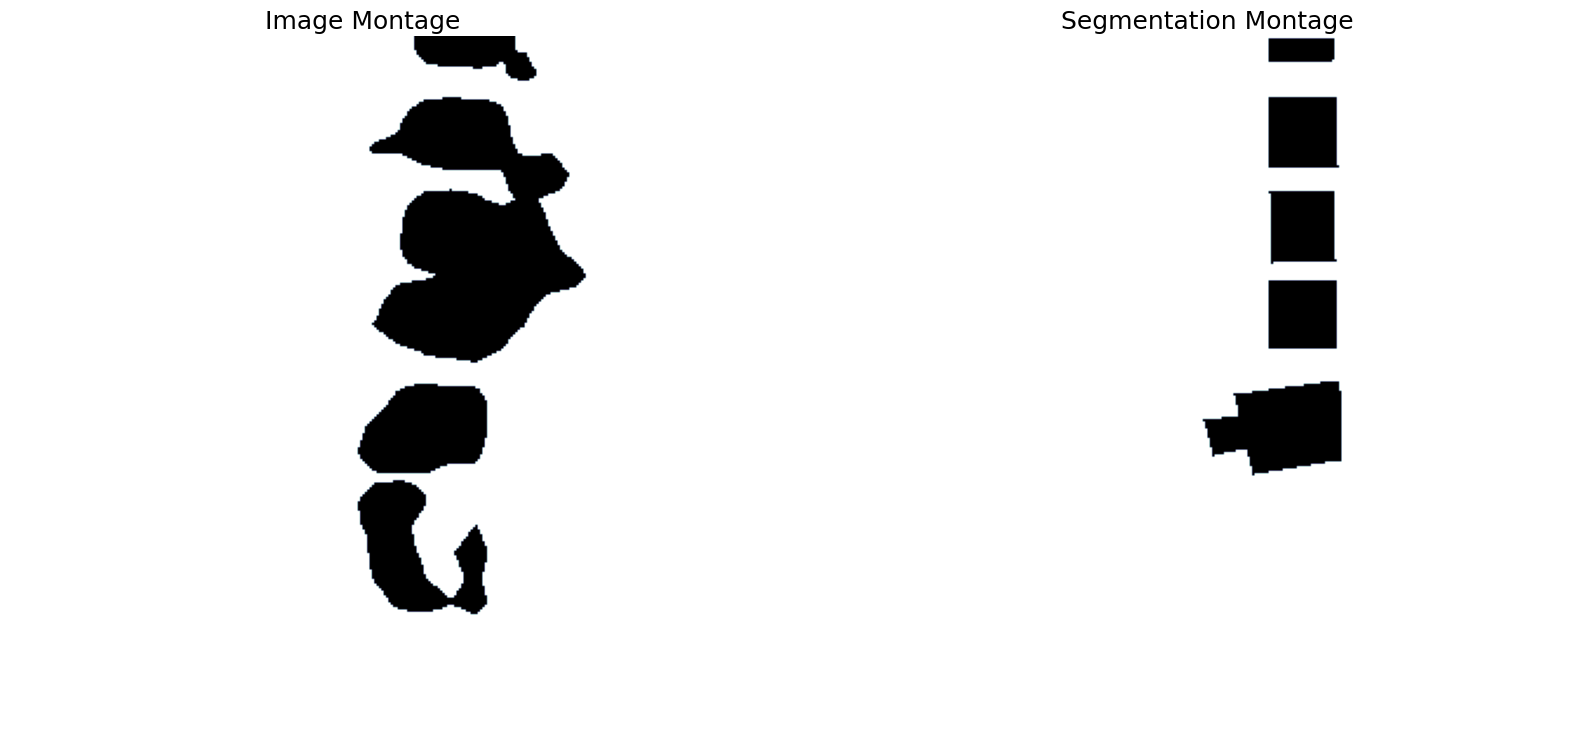

In [56]:
img_montage = montage(output[:, 0, :, :].cpu())  
seg_montage = montage(seg[:, 0, :, :]) 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img_montage, cmap='bone_r')
ax1.set_title('Image Montage', fontsize=18)
ax1.axis('off')

ax2.imshow(seg_montage, cmap='bone_r')
ax2.set_title('Segmentation Montage', fontsize=18)
ax2.axis('off')

plt.show()

# Evaluation Results

- **IoU (Intersection over Union)**: **0.57**  
   - This indicates that 57% of the predicted and actual mask areas overlap. This is a decent result, though there may be room for improvement.

- **Dice Coefficient**: **0.70**  
   - With a Dice score of 0.70, the model captures a significant portion of the target regions, although some areas may be missed or over-predicted. The Dice score is especially helpful for imbalanced datasets, so achieving a value over 0.70 reflects that the model has good sensitivity to finer details.

- **Pixel Accuracy**: **0.89**  
   - With 89% of the pixels classified correctly, the model is making accurate predictions overall. However, this high accuracy might reflect large, correctly classified background areas, which can sometimes inflate pixel accuracy.

---

## Recommendations for Improvement


- **Adjusting Patch Size**: Experimenting with smaller or larger patch sizes could help capture finer details or reduce computational complexity.
- **Hyperparameter Tuning**: Fine-tuning parameters such as the learning rate or batch size may yield improved performance.
- **Adding Encoder Layers**: Increasing the depth of the encoder stack might enable the model to learn more complex representations, particularly for nuanced or small regions.
- **Using a Different Segmentation Head**: Testing alternative segmentation heads, such as attention-based decoders, may help refine mask predictions by enhancing the model’s focus on relevant regions.

With these steps, the Vision Transformer model could potentially achieve higher accuracy. 


# Thank You for Exploring This Notebook!

Thank you for diving into my notebook on Vision Transformers for building segmentation! I hope you found it both insightful and informative. Your feedback is invaluable—please feel free to share any thoughts, suggestions, or questions you may have. If you enjoyed the content or found it helpful, an upvote would be greatly appreciated! 😊 

As for next steps, I’m excited to explore how Vision Transformers can be applied to Image Generation or even Video Generation. (I think it is already used but it is still exciting nevertheless)

I look forward to hearing your feedback, and best of luck with your own projects! 😊😊😊 


